In [1]:
import os
smoke_test = ('CI' in os.environ)  # for continuous integration tests

# various import statements
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
from torch.nn.functional import softplus, softmax, sigmoid
from torch.distributions import constraints
from torch.optim import Adam
import torch.nn.functional as F

from torchdiffeq import odeint_adjoint as odeint

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions.util import broadcast_shape
from pyro.optim import MultiStepLR
from pyro.infer import SVI, config_enumerate, TraceEnum_ELBO
from pyro.contrib.examples.scanvi_data import get_data

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import scvelo as scv

In [2]:
adata = scv.datasets.pancreas()
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=2000)
scv.pp.log1p(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.


/tmp/ipykernel_573/2525943667.py:5: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata)


Filtered out 55 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.
computing neighbors


/home/arataz/NDE/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


AnnData object with n_obs × n_vars = 3696 × 1945
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [3]:
scv.pp.neighbors(adata, n_neighbors=30)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [4]:
adata.obsp['connectivities']

<3696x3696 sparse matrix of type '<class 'numpy.float32'>'
	with 154922 stored elements in Compressed Sparse Row format>

In [5]:
import numpy as np

def self_avoiding_random_walk(adjacency_matrix, start_node, walk_length):
    current_node = start_node
    walk = [current_node]
    
    num_nodes = adjacency_matrix.shape[0]  # Get the number of nodes from the shape attribute
    
    for _ in range(walk_length - 1):
        # Get the neighbors of the current node
        neighbors = np.where(adjacency_matrix[current_node] > 0)[0]
        # Calculate probabilities for transitioning to each neighbor
        neighbor_probs = adjacency_matrix[current_node, neighbors] / np.sum(adjacency_matrix[current_node, neighbors])
        # Choose the next node randomly based on probabilities
        next_node = np.random.choice(neighbors , p=neighbor_probs)
        
        # Append the next node to the walk
        walk.append(next_node)
        # Move to the next node
        current_node = next_node
    
    return walk

walk_length = 32
rw = []
for i in range(adata.obsp['connectivities'].shape[0]):
    start_node = i
    # Perform non-avoiding random walk
    random_walk = self_avoiding_random_walk(adata.obsp['connectivities'].toarray(), start_node, walk_length)
    
    start_node = random_walk[-1]
    rw.append(random_walk)
    

In [6]:
adata.layers['spliced']

<3696x1945 sparse matrix of type '<class 'numpy.float32'>'
	with 1710608 stored elements in Compressed Sparse Row format>

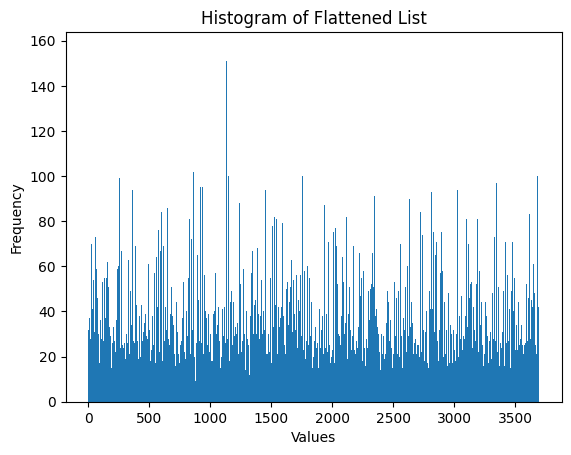

In [7]:
# Flatten the list of lists into a single list
flattened_rw = [item for sublist in rw for item in sublist]

# Plot histogram
plt.hist(flattened_rw, bins=3000)  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Flattened List')
plt.show()

In [8]:
import random


# Calculate the number of lists to choose (30% of the total number of lists)
num_to_choose = int(len(rw) * 0.1)

# Choose 30% of the lists randomly
chosen_rw = random.sample(rw, num_to_choose)

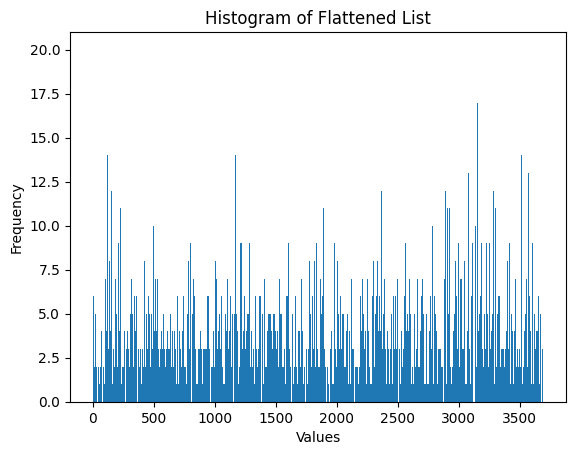

In [9]:
# Flatten the list of lists into a single list
flattened_rw = [item for sublist in chosen_rw for item in sublist]

# Plot histogram
plt.hist(flattened_rw, bins=3000)  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Flattened List')
plt.show()

In [10]:
spliced = []
unspliced = []
ag_adata = []
for i in range(len(chosen_rw)):
    spliced.append(torch.tensor(adata.layers['spliced'][chosen_rw[i]].toarray()))
    unspliced.append(torch.tensor(adata.layers['unspliced'][chosen_rw[i]].toarray()))
    ag_adata.append(adata[chosen_rw[i]])

import scanpy as sc

ag_adata = sc.concat(ag_adata)
spliced_tensor = torch.concat(spliced)
unspliced_tensor = torch.concat(unspliced)

In [11]:
dataset = TensorDataset(spliced_tensor, unspliced_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [12]:
# Helper for making fully-connected neural networks
def make_fc(dims):
    layers = []
    for in_dim, out_dim in zip(dims, dims[1:]):
        layers.append(nn.Linear(in_dim, out_dim))
        layers.append(nn.BatchNorm1d(out_dim))
        layers.append(nn.Softplus())
    return nn.Sequential(*layers[:-1])  # Exclude final Softplus non-linearity

# Splits a tensor in half along the final dimension
def split_in_half(t):
    return t.reshape(t.shape[:-1] + (2, -1)).unbind(-2)
# Used in parameterizing p(s | z2)
class XDecoder(nn.Module):
    # This __init__ statement is executed once upon construction of the neural network.
    # Here we specify that the neural network has input dimension z2_dim
    # and output dimension num_genes.
    def __init__(self, num_genes, z_dim, hidden_dims):
        super().__init__()
        # Create a list to store the layers
        dims = [z_dim] + hidden_dims + [2 * num_genes]
        self.fc = make_fc(dims)
    # This method defines the actual computation of the neural network. It takes
    # z2 as input and spits out two parameters that are then used in the model
    # to define the ZINB observation distribution. In particular it generates
    # `gate_logits`, which controls zero-inflation, and `mu` which encodes the
    # relative frequencies of different genes.
    def forward(self, z):
        gate, mu = split_in_half(self.fc(z))
        # Note that mu is normalized so that total count information is
        # encoded by the latent variable ℓ.
        mu = softmax(mu, dim=-1)
        # gate = sigmoid(gate)
        return gate, mu

In [13]:
# Used in parameterizing q(sl | s)
class LEncoder(nn.Module):
    def __init__(self, num_genes, hidden_dims):
        super().__init__()
        dims = [num_genes] + hidden_dims + [2]
        self.fc = make_fc(dims)

    def forward(self, s):
        # Transform the counts x to log space for increased numerical stability.
        # Note that we only use this transformation here; in particular the observation
        # distribution in the model is a proper count distribution.
        s = torch.log(1 + s)
        l_loc, l_scale = split_in_half(self.fc(s))
        l_scale = softplus(l_scale)
        return l_loc, l_scale

In [48]:
# Used in parameterizing p(z2 | z1, s)
class XEncoder(nn.Module):
    def __init__(self, z_dim,num_genes, hidden_dims):
        super().__init__()
        dims = [2* num_genes] + hidden_dims + [2 * z_dim + 2]
        self.fc = make_fc(dims)
        self.sigmoid = nn.Sigmoid()
    def forward(self, u, s):
        u = u.type(torch.float32)
        s = s.type(torch.float32)
        x = torch.cat([s, u], dim=-1)
        # We reshape the input to be two-dimensional so that nn.BatchNorm1d behaves correctly
        x = x.reshape(-1, x.size(-1))
        hidden = self.fc(x)
        # If the input was three-dimensional we now restore the original shape
        hidden = hidden.reshape(x.shape[:-1] + hidden.shape[-1:])
        # t = hidden[...,-1]
        # hidden = hidden[...,:-1]
        loc, scale = split_in_half(hidden)
        loc_z = loc[... , :-1]
        loc_t = loc[... ,-1]
        scale_z = scale[... , :-1]
        scale_t = scale[... ,-1]
        
        # Here and elsewhere softplus ensures that scale is positive. Note that we generally
        # expect softplus to be more numerically stable than exp.
        scale_z = softplus(scale_z)
        scale_t = softplus(scale_t)
        loc_t = self.sigmoid(loc_t)
        return loc_z, scale_z, loc_t, scale_t

In [41]:
class ODEFunc(nn.Module):
    def __init__(self,z_dim = 10):
        super().__init__()
        self.latent_dim = z_dim
        self.f = nn.Sequential(
            nn.Linear(self.latent_dim, self.latent_dim),
            nn.Softplus(),
            nn.Linear(self.latent_dim, self.latent_dim),
            nn.Softplus(),
            nn.Linear(self.latent_dim, self.latent_dim))

    def forward(self, t, y):
        
        return self.f(y)


In [42]:
def perturb_tensor(tensor, epsilon=1e-4):
    # Flatten the tensor to 1D
    flat_tensor = tensor
    
    # Check for unique elements
    unique_elements, counts = torch.unique(flat_tensor, return_counts=True)
    
    # Find repeated elements
    repeated_elements = unique_elements[counts > 1]
    
    # If there are repeated elements, perturb them slightly
    if len(repeated_elements) > 0:
        for elem in repeated_elements:
            # Find indices of repeated elements
            indices = torch.nonzero(flat_tensor == elem).squeeze()
            
            # Perturb the repeated elements slightly
            flat_tensor[indices] += torch.randn_like(flat_tensor[indices]) * epsilon
    
    # Reshape the perturbed tensor to its original shape
    perturbed_tensor = flat_tensor.view(tensor.shape)
    
    return perturbed_tensor

In [54]:
class VAE(nn.Module):
    def __init__(self, num_genes, sl_loc, sl_scale, ul_loc, ul_scale,
                 latent_dim=10, alpha=0.01, scale_factor=1.0):
        self.num_genes = num_genes

        # This is the dimension of both z1 and z2
        self.latent_dim = latent_dim

        # The next two hyperparameters determine the prior over the log_count latent variable `l`
        self.ul_loc = ul_loc
        self.ul_scale = ul_scale
        self.sl_loc = sl_loc
        self.sl_scale = sl_scale

        # This hyperparameter controls the strength of the auxiliary classification loss
        # self.alpha = alpha
        self.scale_factor = scale_factor

        super().__init__()

        # Setup the various neural networks used in the model and guide
        self.x_encoder = XEncoder(z_dim=self.latent_dim, num_genes=self.num_genes,
                                    hidden_dims=[128 , 64])
        self.u_decoder = XDecoder(num_genes=num_genes, hidden_dims=[64, 128], z_dim=self.latent_dim)
        self.s_decoder = XDecoder(num_genes=num_genes, hidden_dims=[64, 128], z_dim=self.latent_dim)
        self.sl_encoder = LEncoder(num_genes=num_genes, hidden_dims=[64 , 32])
        self.ul_encoder = LEncoder(num_genes=num_genes, hidden_dims=[64 , 32])
        self.ode_func = ODEFunc(z_dim =  self.latent_dim)

        self.epsilon = 0.003

    def model(self, u, s):
        # Register various nn.Modules (i.e. the decoder/encoder networks) with Pyro
        pyro.module("VAE", self)

        # This gene-level parameter modulates the variance of the observation distribution
        theta_u = pyro.param("inverse_dispersion_unspliced", 100.0 * u.new_ones(self.num_genes),
                           constraint=constraints.positive)
        theta_s = pyro.param("inverse_dispersion_spliced", 100.0 * s.new_ones(self.num_genes),
                           constraint=constraints.positive)

        # We scale all sample statements by scale_factor so that the ELBO loss function
        # is normalized wrt the number of datapoints and genes.
        # This helps with numerical stability during optimization.
        with pyro.plate("batch", len(u)), poutine.scale(scale=self.scale_factor):
            z = pyro.sample("z", dist.Normal(0, u.new_ones(self.latent_dim)).to_event(1))
            t = pyro.sample("t", dist.Normal(torch.zeros(1).cuda(),torch.ones(1).cuda()).to_event(0))
            # t = (t + 0.001* torch.randn_like(t))
            index = torch.argsort(t)
            original_index = torch.argsort(index)
            t_ode = t[index]
            IC = z[index][0]
            z_hat = odeint(self.ode_func, IC, t_ode).squeeze().cuda()
            z_hat = z_hat[original_index]

            
            gate_logits_u, mu_u = self.u_decoder(z_hat)
            ul_scale = self.ul_scale * u.new_ones(1)
            ul = pyro.sample("ul", dist.LogNormal(self.ul_loc, ul_scale).to_event(1))
            rate_u = (ul * mu_u + self.epsilon).log() - (theta_u + self.epsilon).log()
            u_dist = dist.ZeroInflatedNegativeBinomial(gate_logits=gate_logits_u, total_count=theta_u,
                                                       logits=rate_u)
            u_hat = pyro.sample("u", u_dist.to_event(1), obs=u)


            sl_scale = self.sl_scale * s.new_ones(1)
            sl = pyro.sample("sl", dist.LogNormal(self.sl_loc, sl_scale).to_event(1))
            # Note that by construction mu is normalized (i.e. mu.sum(-1) == 1) and the
            # total scale of counts for each cell is determined by `l`
            gate_logits_s, mu_s = self.s_decoder(z_hat)
            rate_s = (sl * mu_s + self.epsilon).log() - (theta_s + self.epsilon).log()
            s_dist = dist.ZeroInflatedNegativeBinomial(gate_logits=gate_logits_s, total_count=theta_s,
                                                       logits=rate_s)
            # Observe the datapoint x using the observation distribution x_dist
            pyro.sample("s", s_dist.to_event(1), obs=s)
            

    # The guide specifies the variational distribution
    def guide(self, u, s):
        pyro.module("VAE", self)
        with pyro.plate("batch", len(u)), poutine.scale(scale=self.scale_factor):
            z_loc , z_scale, t_loc, t_scale = self.x_encoder(u,s)
            sl_loc, sl_scale = self.sl_encoder(s)
            pyro.sample("sl", dist.LogNormal(sl_loc, sl_scale).to_event(1))
            pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))
            pyro.sample("t", dist.Normal(t_loc, t_scale).to_event(0))
            ul_loc, ul_scale = self.ul_encoder(u)
            pyro.sample("ul", dist.LogNormal(ul_loc, ul_scale).to_event(1))

In [55]:
def prepare_vae(adata, batch_size=128):
    num_genes = len(adata.var)

    # Calculate library size (total counts) for each cell
    spliced_library_size = np.log(adata.layers['spliced'].sum(axis=1))

    # Calculate mean and scale for spliced layer
    sl_mean = spliced_library_size.mean()
    sl_scale = spliced_library_size.std()

    # Calculate library size for unspliced layer
    unspliced_library_size = np.log(adata.layers['unspliced'].sum(axis=1))

    # Calculate mean and scale for unspliced layer
    ul_mean = unspliced_library_size.mean()
    ul_scale = unspliced_library_size.std()

    # Instantiate instance of model/guide and various neural networks
    vae = VAE(num_genes=num_genes,
              sl_loc=sl_mean, sl_scale=sl_scale, ul_loc=ul_mean, ul_scale=ul_scale,
              scale_factor=1.0 / (batch_size * num_genes))

    return vae

In [56]:
def get_t(t):
    try:
        # Your code that raises the AssertionError
        assert ((t[1:] - t[:-1]).sign() > 0).all(), "t must be strictly increasing or decreasing"
    except AssertionError as e:
        print("AssertionError:", e)
        print("t:", t)
        raise

In [57]:
from tqdm import tqdm
def train_vae(adata,data_loader, num_epochs=80,batch_size = 32, smoke_test=False):
    # Clear Pyro param store so we don't conflict with previous
    # training runs in this session
    pyro.clear_param_store()

    # Fix random number seed
    pyro.util.set_rng_seed(42)

    # Enable optional validation warnings
    pyro.enable_validation(True)

    num_genes = len(adata.var)
    vae = prepare_vae(adata, batch_size)
    if not smoke_test:
        vae = vae.cuda()
    optimizer = torch.optim.Adam(vae.parameters(), lr=0.001, betas=(0.90, 0.999))
    elbo = pyro.infer.TraceEnum_ELBO(strict_enumeration_warning=False).differentiable_loss
    # ode_optimizer = Adam(vae.ode_func.parameters(), lr=0.006)
    mse = nn.MSELoss()
    # Training loop.
    # We train for num_epochs epochs.
    # For optimal results, tweak the optimization parameters.
    # For our purposes, 80 epochs of training is sufficient.
    # Training should take about 8 minutes on a GPU-equipped Colab instance.

    losses = []

    for epoch in range(num_epochs):
        epoch_losses = []

        # Take a gradient step for each mini-batch in the dataset
        for s,u in tqdm(data_loader, desc=f'Epoch {epoch}'):
            s, u = s.cuda(), u.cuda()
            u = u.type(torch.int)
            s = s.type(torch.int)
            z_loc, z_scale ,t_loc, t_scale = vae.x_encoder(u,s)
            t = t_loc
            t = (t + t_scale* torch.randn_like(t))
            z = z_loc + z_scale*torch.randn_like(z_loc)
            index = torch.argsort(t)
            original_index = torch.argsort(index)
            t_ode = t[index]
            IC = z[index][0]
            z_hat = odeint(vae.ode_func, IC, t_ode).squeeze().cuda()
            z_hat = z_hat[original_index]
            
            loss = elbo(vae.model, vae.guide,u,s) + mse(z_hat,z)
            epoch_losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss_mean = np.mean(epoch_losses)
        losses.append(epoch_loss_mean)

        if epoch%1 ==0:
            print(f"[Epoch {epoch}]  Loss: {epoch_loss_mean:.5f}")

    print("Finished training!")

    # Plot the loss function
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return vae

Epoch 0: 100%|██████████| 369/369 [10:08<00:00,  1.65s/it]


[Epoch 0]  Loss: 9.09843


Epoch 1: 100%|██████████| 369/369 [10:17<00:00,  1.67s/it]


[Epoch 1]  Loss: 7.21531


Epoch 2: 100%|██████████| 369/369 [10:18<00:00,  1.68s/it]


[Epoch 2]  Loss: 6.29345


Epoch 3: 100%|██████████| 369/369 [10:22<00:00,  1.69s/it]


[Epoch 3]  Loss: 5.49723


Epoch 4: 100%|██████████| 369/369 [10:25<00:00,  1.70s/it]


[Epoch 4]  Loss: 4.83061


Epoch 5: 100%|██████████| 369/369 [10:20<00:00,  1.68s/it]


[Epoch 5]  Loss: 4.31614


Epoch 6: 100%|██████████| 369/369 [10:30<00:00,  1.71s/it]


[Epoch 6]  Loss: 3.87957


Epoch 7: 100%|██████████| 369/369 [10:32<00:00,  1.71s/it]


[Epoch 7]  Loss: 3.52613


Epoch 8: 100%|██████████| 369/369 [10:27<00:00,  1.70s/it]


[Epoch 8]  Loss: 3.23306


Epoch 9: 100%|██████████| 369/369 [10:36<00:00,  1.73s/it]

[Epoch 9]  Loss: 2.95364
Finished training!


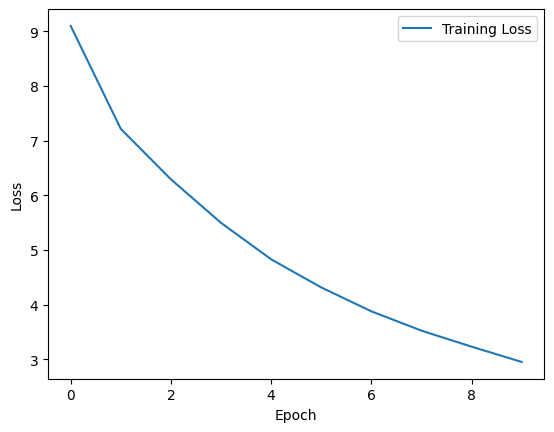

In [58]:
trained_vae = train_vae(adata,data_loader, num_epochs=10)

<Figure size 1200x500 with 0 Axes>

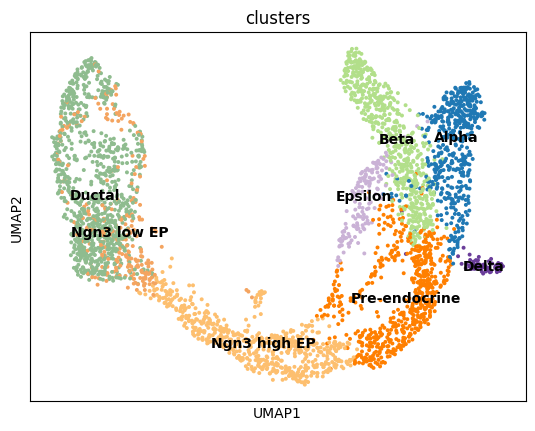

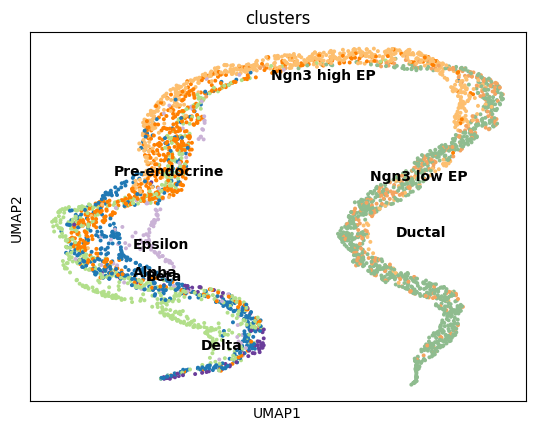

In [59]:
# Plot the original UMAP
plt.figure(figsize=(12, 5))
sc.pl.umap(adata, color= 'clusters', legend_loc='on data', save='scVelo_umap_plot.png')

# Generate latent representations using the trained VAE
trained_vae.eval()
unspliced_tensor = torch.tensor(adata.layers['unspliced'].toarray())
spliced_tensor = torch.tensor(adata.layers['spliced'].toarray())
latent_rep = trained_vae.x_encoder( unspliced_tensor.cuda(), spliced_tensor.cuda())[0]
adata.obsm["latent_rep"] = latent_rep.data.cpu().numpy()

# Update neighbors and UMAP with latent representations
sc.pp.neighbors(adata, use_rep="latent_rep")
sc.tl.umap(adata)

# Plot the UMAP based on VAE latent representations
sc.pl.umap(adata, color= 'clusters', legend_loc='on data', save='LSD_umap_plot.png')

In [96]:
scv.tl.velocity(adata)

computing velocities


/home/arataz/NDE/lib/python3.10/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [98]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/44 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


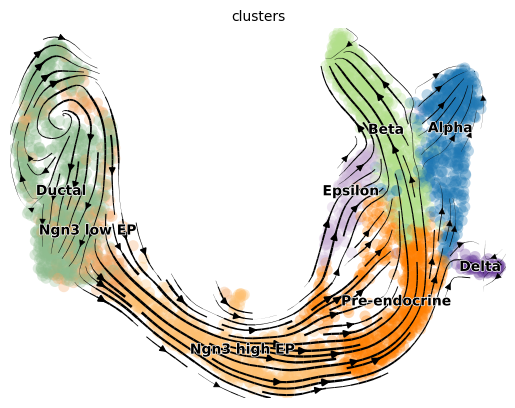

In [99]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

In [102]:
adata

AnnData object with n_obs × n_vars = 3696 × 1945
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'log1p', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

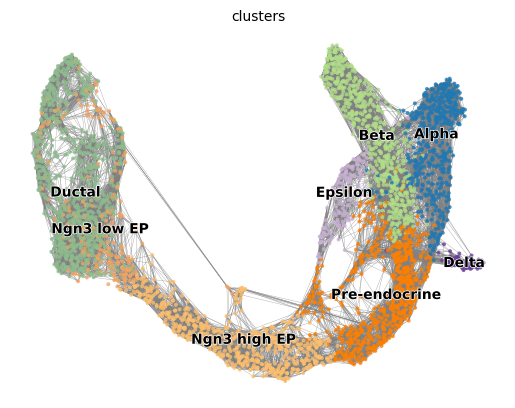

In [103]:
scv.pl.velocity_graph(adata, threshold=.1)

In [101]:
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 640x480 with 2 Axes>

In [60]:
enc = trained_vae.x_encoder( unspliced_tensor.cuda(), spliced_tensor.cuda())
t = enc[2]/(enc[2]+enc[3])
adata.obs["time"] = t.data.cpu().numpy()

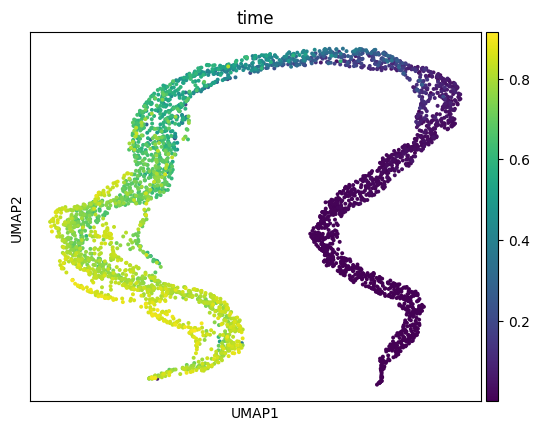

In [61]:
sc.pl.umap(adata, color= 'time', legend_loc='on data', save='LSD_umap_plot.png')

In [62]:
velocity = trained_vae.ode_func(t= None,y = latent_rep)

In [63]:
adata.obsm['Neural_velocity'] = velocity.data.cpu().numpy()

In [64]:
test = sc.AnnData()
var = [i for i in range(10)]
test.var["latent_features"] = var 
test.obs['clusters'] = adata.obs["clusters"]
test.obs['time'] = adata.obs["time"]
test.layers["latent_rep"] = adata.obsm["latent_rep"]
test.obsm["latent_rep"] = adata.obsm["latent_rep"]
test.layers["velocity"] = adata.obsm['Neural_velocity']

In [65]:
# Update neighbors and UMAP with latent representations
sc.pp.neighbors(test, use_rep="latent_rep")
sc.tl.umap(test)

In [66]:
test

AnnData object with n_obs × n_vars = 3696 × 10
    obs: 'clusters', 'time'
    var: 'latent_features'
    uns: 'neighbors', 'umap'
    obsm: 'latent_rep', 'X_umap'
    layers: 'latent_rep', 'velocity'
    obsp: 'distances', 'connectivities'

In [67]:
scv.tl.velocity_graph(test,vkey='velocity',xkey = "latent_rep")

computing velocity graph (using 1/28 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


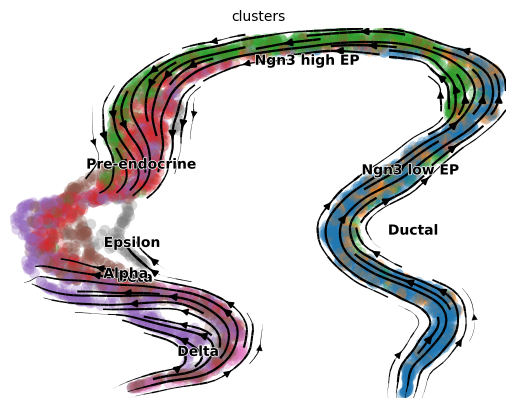

In [68]:
scv.pl.velocity_embedding_stream(test, basis='umap')

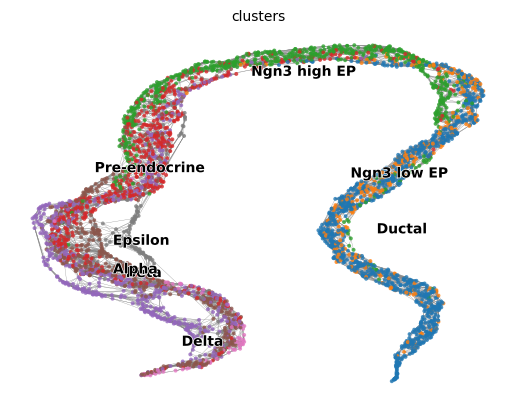

In [69]:
scv.pl.velocity_graph(test, threshold=.1)

In [70]:
sc.write("t_normal_10epochs.h5ad", test)

/home/arataz/NDE/lib/python3.10/site-packages/h5py/_hl/attrs.py:104: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.create(name, data=value)
/home/arataz/NDE/lib/python3.10/site-packages/h5py/_hl/filters.py:250: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  chunks = guess_chunk(shape, maxshape, dtype.itemsize)
